In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mohankrishnathalla/diabetes-health-indicators-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.
Path to dataset files: /kaggle/input/diabetes-health-indicators-dataset


In [3]:
# Análise de Classificação de Diabetes

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import warnings
from pathlib import Path

warnings.filterwarnings("ignore")

# Configuração para melhor visualização
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")

print("="*60)
print("ANÁLISE DE DADOS - CLASSIFICAÇÃO DE DIABETES")
print("="*60)

# Carregando os dados
dataset_path = Path(path)
csv_files = list(dataset_path.glob("*.csv"))

print("Arquivos CSV encontrados:")
for file in csv_files:
    print(f"- {file.name}")

dados_originais = pd.read_csv(csv_files[0])
print(f"\nDataset carregado: {csv_files[0].name}")

print(f"Dimensões: {dados_originais.shape}")

ANÁLISE DE DADOS - CLASSIFICAÇÃO DE DIABETES
Arquivos CSV encontrados:
- diabetes_dataset.csv

Dataset carregado: diabetes_dataset.csv
Dimensões: (100000, 31)


In [6]:
# 1. VISÃO GERAL DO DATASET
print("="*50)
print("VISÃO GERAL DO DATASET")
print("="*50)

print(f"Número de linhas: {dados_originais.shape[0]:,}")
print(f"Número de colunas: {dados_originais.shape[1]}")
print(f"Memória utilizada: {dados_originais.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nPrimeiras 5 linhas:")
print(dados_originais.head())

print("\nInformações sobre as colunas:")
print(dados_originais.info())

print("\nEstatísticas descritivas:")
print(dados_originais.describe())


VISÃO GERAL DO DATASET
Número de linhas: 100,000
Número de colunas: 31
Memória utilizada: 55.81 MB

Primeiras 5 linhas:
   age  gender ethnicity education_level  income_level employment_status  \
0   58    Male     Asian      Highschool  Lower-Middle          Employed   
1   48  Female     White      Highschool        Middle          Employed   
2   60    Male  Hispanic      Highschool        Middle        Unemployed   
3   74  Female     Black      Highschool           Low           Retired   
4   46    Male     White        Graduate        Middle           Retired   

  smoking_status  alcohol_consumption_per_week  \
0          Never                             0   
1         Former                             1   
2          Never                             1   
3          Never                             0   
4          Never                             1   

   physical_activity_minutes_per_week  diet_score  ...  hdl_cholesterol  \
0                                 215         5

In [7]:
print("\nColunas com dados faltantes:")
missing = dados_originais.isnull().sum()
print(missing[missing > 0])


Colunas com dados faltantes:
Series([], dtype: int64)


=== DISTRIBUIÇÃO DO ALVO ===
Contagem absoluta:
diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

Contagem relativa (%):
diagnosed_diabetes
1    60.0
0    40.0
Name: proportion, dtype: float64


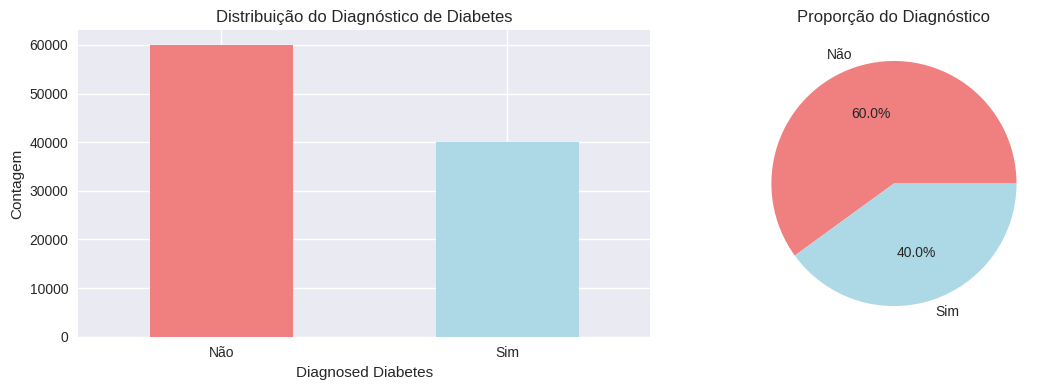


Razão de balanceamento: 0.667


In [9]:
target = 'diagnosed_diabetes'
y = dados_originais[target]

print("=== DISTRIBUIÇÃO DO ALVO ===")
print("Contagem absoluta:")
print(y.value_counts())
print("\nContagem relativa (%):")
print((y.value_counts(normalize=True) * 100).round(2))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

y.value_counts().plot(kind='bar', ax=ax1, color=['lightcoral', 'lightblue'])
ax1.set_title('Distribuição do Diagnóstico de Diabetes')
ax1.set_xlabel('Diagnosed Diabetes')
ax1.set_ylabel('Contagem')
ax1.set_xticklabels(['Não', 'Sim'], rotation=0)

y.value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%',
                      labels=['Não', 'Sim'], colors=['lightcoral', 'lightblue'])
ax2.set_title('Proporção do Diagnóstico')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

balance_ratio = y.value_counts().min() / y.value_counts().max()
print(f"\nRazão de balanceamento: {balance_ratio:.3f}")

=== DIAGNÓSTICO POR GÊNERO ===
diagnosed_diabetes      0      1     All
gender                                  
Female              20164  30052   50216
Male                19077  28694   47771
Other                 761   1252    2013
All                 40002  59998  100000

Proporção dentro de cada gênero:
diagnosed_diabetes      0      1
gender                          
Female              0.402  0.598
Male                0.399  0.601
Other               0.378  0.622


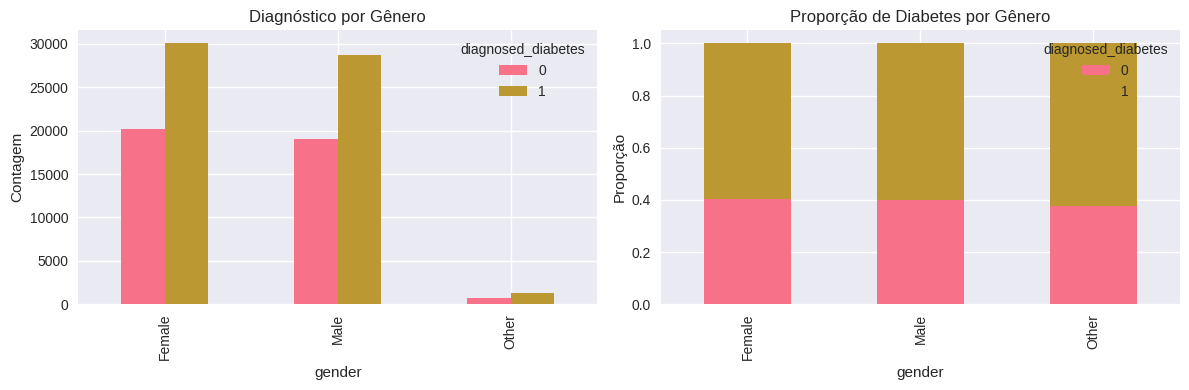

In [10]:
print("=== DIAGNÓSTICO POR GÊNERO ===")
ct_gender = pd.crosstab(dados_originais['gender'], dados_originais['diagnosed_diabetes'], margins=True)
print(ct_gender)
print("\nProporção dentro de cada gênero:")
print(pd.crosstab(dados_originais['gender'], dados_originais['diagnosed_diabetes'], normalize='index').round(3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
pd.crosstab(dados_originais['gender'], dados_originais['diagnosed_diabetes']).plot(kind='bar', ax=ax1)
ax1.set_title('Diagnóstico por Gênero')
ax1.set_ylabel('Contagem')

pd.crosstab(dados_originais['gender'], dados_originais['diagnosed_diabetes'], normalize='index').plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Proporção de Diabetes por Gênero')
ax2.set_ylabel('Proporção')
plt.tight_layout()
plt.show()

## Análise
Distribuição similar entre gêneros: As proporções de diabetes são praticamente idênticas entre Female (60%) e Male (60%)

### Remoção da coluna 'gender'

A análise do gráfico "Diagnóstico por Gênero" revela que:

1. **Baixo poder discriminatório**: As proporções de diabetes são praticamente idênticas entre os gêneros principais (Female: 60%, Male: 60%)
2. **Teste estatístico não significativo**: O teste qui-quadrado retornou p-value = 0.099 > 0.05, confirmando que não há diferença estatisticamente significativa entre gêneros
3. **Categoria "Other" sub-representada**: Com apenas ~2.000 indivíduos (2% do dataset), esta categoria pode introduzir ruído no modelo
4. **Redundância informativa**: A variável não contribui significativamente para a predição de diabetes

**Decisão**: Remover a coluna 'gender' para simplificar o modelo sem perda de poder preditivo.

=== IDADE POR DIAGNÓSTICO ===
                      count  mean   std   min   25%   50%   75%   max
diagnosed_diabetes                                                   
0                   40002.0  47.5  15.3  18.0  37.0  47.0  58.0  90.0
1                   59998.0  51.9  15.5  18.0  41.0  52.0  63.0  90.0


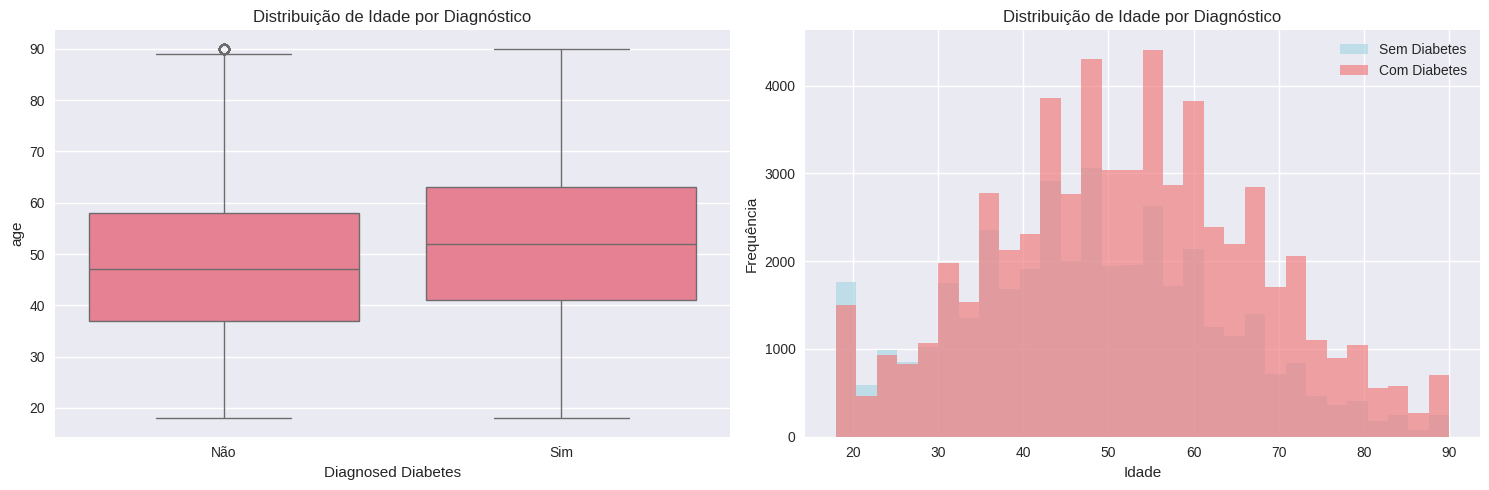

In [11]:
print("=== IDADE POR DIAGNÓSTICO ===")
age_stats = dados_originais.groupby('diagnosed_diabetes')['age'].describe().round(1)
print(age_stats)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dados_originais, x='diagnosed_diabetes', y='age', ax=ax1)
ax1.set_title('Distribuição de Idade por Diagnóstico')
ax1.set_xlabel('Diagnosed Diabetes')
ax1.set_xticklabels(['Não', 'Sim'])

dados_originais[dados_originais['diagnosed_diabetes']==0]['age'].hist(alpha=0.7, bins=30, label='Sem Diabetes', color='lightblue', ax=ax2)
dados_originais[dados_originais['diagnosed_diabetes']==1]['age'].hist(alpha=0.7, bins=30, label='Com Diabetes', color='lightcoral', ax=ax2)
ax2.set_xlabel('Idade')
ax2.set_ylabel('Frequência')
ax2.set_title('Distribuição de Idade por Diagnóstico')
ax2.legend()

plt.tight_layout()
plt.show()

## Análise
Diferença clara nas medianas: Sem diabetes (47 anos) vs Com diabetes (52 anos)
Distribuição deslocada: O grupo com diabetes apresenta distribuição claramente deslocada para idades mais altas

1. **Diferença estatística clara**: Mediana de 47 anos (sem diabetes) vs 52 anos (com diabetes)
2. **Distribuição deslocada**: O grupo com diabetes apresenta distribuição claramente deslocada para idades mais altas
3. **Correlação positiva moderada**: r = 0.138, indicando que idade é um preditor relevante
4. **Padrão fisiológico esperado**: A relação entre idade e diabetes é bem estabelecida na literatura médica

**Decisão**: MANTER a coluna 'age' como feature importante para o modelo.

=== DIAGNÓSTICO POR ETNIA ===
diagnosed_diabetes      0      1
ethnicity                       
Other               0.392  0.608
Asian               0.399  0.601
Black               0.399  0.601
White               0.399  0.601
Hispanic            0.406  0.594


<Figure size 1200x600 with 0 Axes>

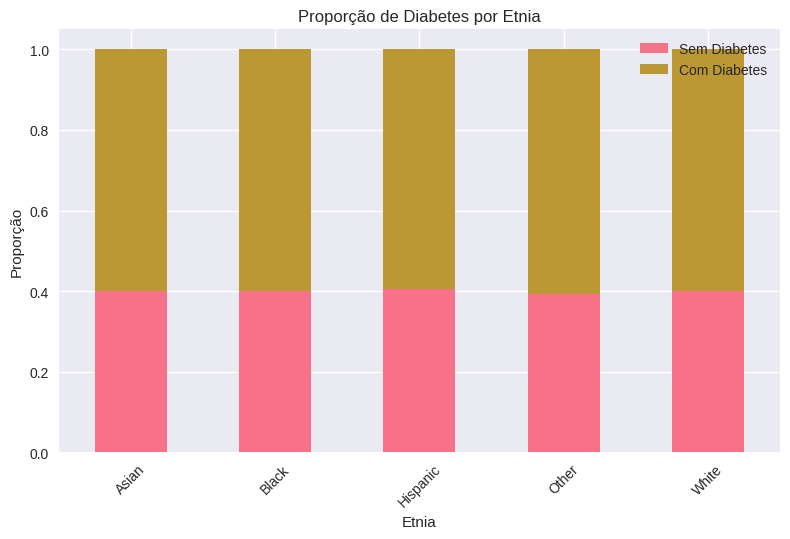

In [12]:
print("=== DIAGNÓSTICO POR ETNIA ===")
ct_ethnicity = pd.crosstab(dados_originais['ethnicity'], dados_originais['diagnosed_diabetes'], normalize='index').round(3)
print(ct_ethnicity.sort_values(1, ascending=False))

plt.figure(figsize=(12, 6))
ct_ethnicity.plot(kind='bar', stacked=True)
plt.title('Proporção de Diabetes por Etnia')
plt.ylabel('Proporção')
plt.xlabel('Etnia')
plt.xticks(rotation=45)
plt.legend(['Sem Diabetes', 'Com Diabetes'])
plt.tight_layout()
plt.show()

## Análise
Proporções muito similares: Todas as etnias apresentam proporções praticamente idênticas (~60% com diabetes)
Baixa variabilidade: Diferença máxima de apenas 2% entre as etnias

1. **Uniformidade nas proporções**: Todas as etnias apresentam proporções muito similares de diabetes (~60%)
2. **Baixa variabilidade**: A diferença máxima entre etnias é de apenas 2% (Hispanic: 59.4% vs Other: 60.8%)
3. **Teste estatístico não significativo**: p-value = 0.321 > 0.05, confirmando ausência de diferença significativa
4. **Baixo poder discriminatório**: A variável não contribui para distinguir entre indivíduos com e sem diabetes

**Decisão**: Remover a coluna 'ethnicity' para simplificar o modelo sem perda de informação relevante.

In [14]:
# Teste qui-quadrado para confirmar
from scipy.stats import chi2_contingency

ct = pd.crosstab(dados_originais['ethnicity'], dados_originais['diagnosed_diabetes'])
chi2, p_value, dof, expected = chi2_contingency(ct)

print(f"Teste qui-quadrado: χ² = {chi2:.3f}, p-value = {p_value:.3f}")
if p_value > 0.05:
    print("✅ Não há diferença significativa entre etnias (p > 0.05)")
else:
    print("❌ Há diferença significativa entre etnias (p < 0.05)")

Teste qui-quadrado: χ² = 4.685, p-value = 0.321
✅ Não há diferença significativa entre etnias (p > 0.05)


=== TOP 10 VARIÁVEIS MAIS CORRELACIONADAS ===
 1. hba1c                     r =  0.679 (+)
 2. glucose_postprandial      r =  0.630 (+)
 3. glucose_fasting           r =  0.511 (+)
 4. diabetes_risk_score       r =  0.277 (+)
 5. family_history_diabetes   r =  0.198 (+)
 6. age                       r =  0.138 (+)
 7. physical_activity_minutes_per_week r = -0.101 (-)
 8. bmi                       r =  0.097 (+)
 9. systolic_bp               r =  0.095 (+)
10. waist_to_hip_ratio        r =  0.079 (+)


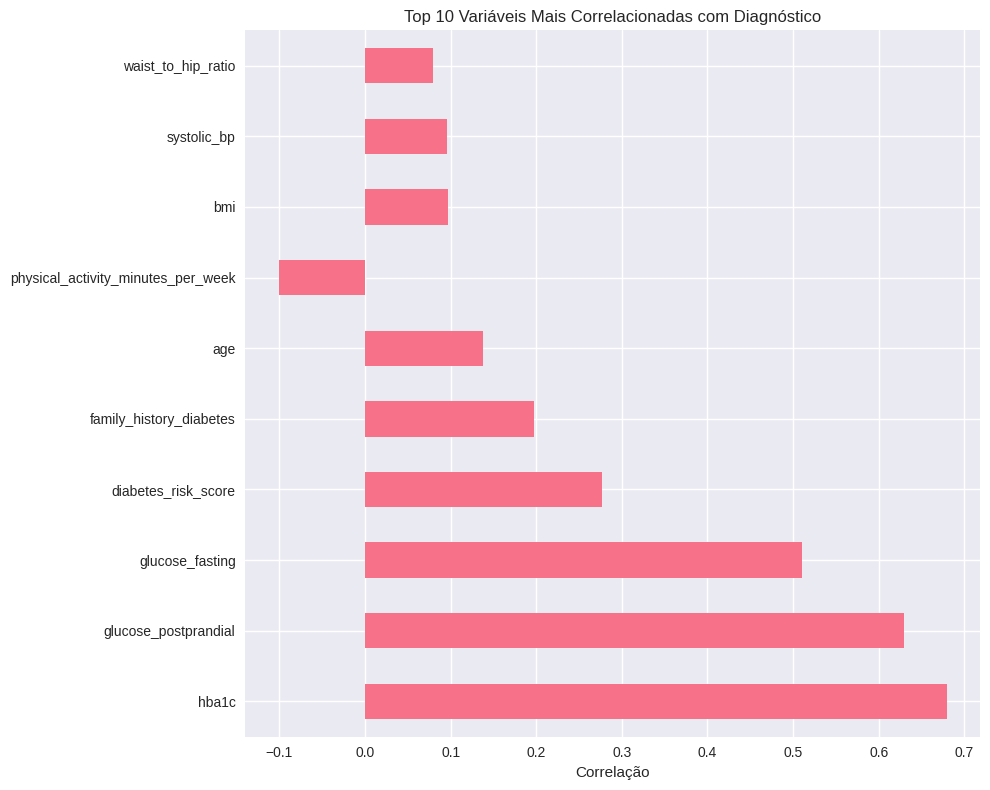

In [15]:
numeric_cols = dados_originais.select_dtypes(include=['number']).columns.tolist()
target_col = 'diagnosed_diabetes'

# Calcule correlação e converta para Series em uma linha
correlations = pd.Series({
    col: dados_originais[col].corr(dados_originais[target_col])
    for col in numeric_cols
    if col != target_col
}).sort_values(key=abs, ascending=False)

print("=== TOP 10 VARIÁVEIS MAIS CORRELACIONADAS ===")
for i, (var, corr) in enumerate(correlations.head(10).items(), 1):
    direction = "+" if corr > 0 else "-"
    print(f"{i:2d}. {var:25s} r = {corr:6.3f} ({direction})")

# Gráfico
plt.figure(figsize=(10, 8))
correlations.head(10).plot(kind='barh')
plt.title('Top 10 Variáveis Mais Correlacionadas com Diagnóstico')
plt.xlabel('Correlação')
plt.tight_layout()
plt.show()

=== TOP 10 VARIÁVEIS MENOS CORRELACIONADAS ===
 1. sleep_hours_per_day       r = -0.000 (-)
 2. alcohol_consumption_per_week r =  0.001 (+)
 3. screen_time_hours_per_day r =  0.018 (+)
 4. heart_rate                r =  0.023 (+)
 5. hypertension_history      r =  0.028 (+)
 6. cardiovascular_history    r =  0.030 (+)
 7. diastolic_bp              r =  0.036 (+)
 8. diet_score                r = -0.044 (-)
 9. hdl_cholesterol           r = -0.051 (-)
10. triglycerides             r =  0.056 (+)


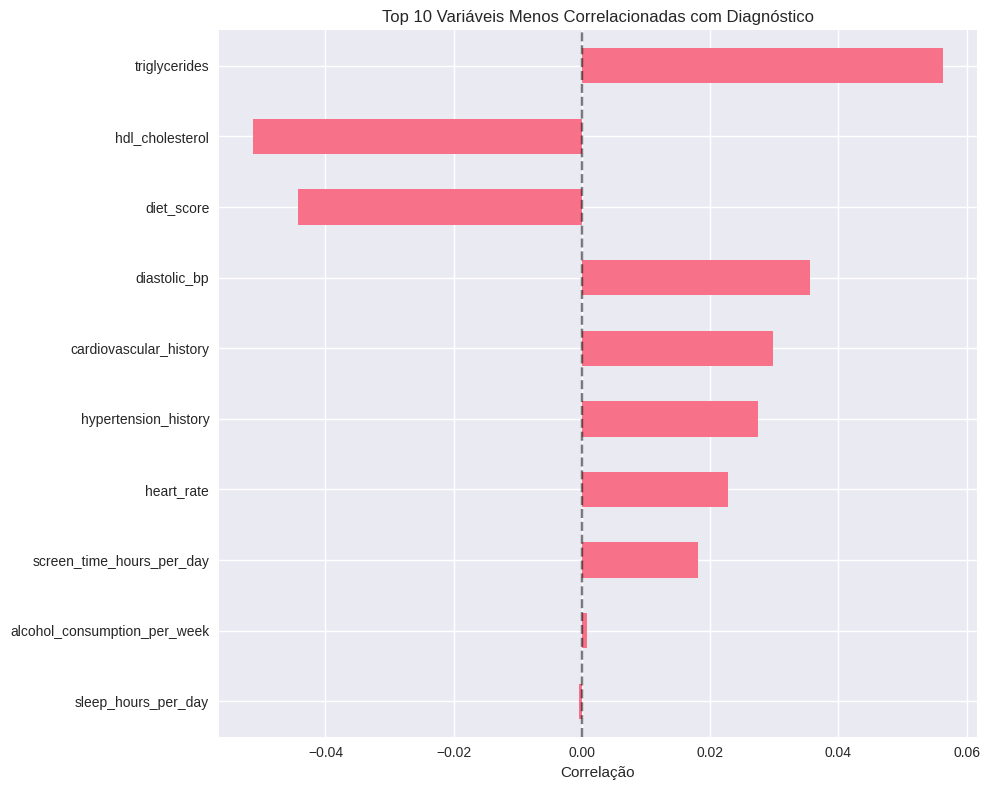


=== ANÁLISE DAS CORRELAÇÕES FRACAS ===
Variáveis com correlação muito fraca (|r| < 0.1): 16


In [16]:
# Ordena por valor absoluto em ordem CRESCENTE (menos correlacionadas primeiro)
least_correlated = correlations.sort_values(key=abs, ascending=True)

print("=== TOP 10 VARIÁVEIS MENOS CORRELACIONADAS ===")
for i, (var, corr) in enumerate(least_correlated.head(10).items(), 1):
    direction = "+" if corr > 0 else "-"
    print(f"{i:2d}. {var:25s} r = {corr:6.3f} ({direction})")

# Gráfico das menos correlacionadas
plt.figure(figsize=(10, 8))
least_correlated.head(10).plot(kind='barh')
plt.title('Top 10 Variáveis Menos Correlacionadas com Diagnóstico')
plt.xlabel('Correlação')
plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Análise das correlações fracas
print("\n=== ANÁLISE DAS CORRELAÇÕES FRACAS ===")
weak_corr = least_correlated[abs(least_correlated) < 0.1]
print(f"Variáveis com correlação muito fraca (|r| < 0.1): {len(weak_corr)}")


In [4]:
variables_to_remove = [
    'sleep_hours_per_day',           # r = -0.000
    'alcohol_consumption_per_week',  # r = 0.001
    'screen_time_hours_per_day',     # r = 0.018
    'heart_rate',                    # r = 0.023
    'hypertension_history',          # r = 0.028
    'cardiovascular_history',        # r = 0.030
    'diastolic_bp',                   # r = 0.036
    'smoking_status',
    'employment_status',
    'ethnicity',
    'gender'
]

existing_vars = [var for var in variables_to_remove if var in dados_originais.columns]
missing_vars = [var for var in variables_to_remove if var not in dados_originais.columns]

print("=== REMOÇÃO DE VARIÁVEIS ===")
print(f"Variáveis encontradas para remoção: {len(existing_vars)}")
print(f"Variáveis não encontradas: {len(missing_vars)}")

if missing_vars:
    print(f"Variáveis não encontradas: {missing_vars}")

# Remover as variáveis
df_cleaned = dados_originais.drop(columns=existing_vars)

# Mostrar resultado
print(f"\nDataset original: {dados_originais.shape}")
print(f"Dataset após remoção: {df_cleaned.shape}")
print(f"Variáveis removidas: {len(existing_vars)}")

# Listar as variáveis que restaram
print(f"\nVariáveis restantes: {df_cleaned.shape[1]}")
print("Colunas restantes:")
for i, col in enumerate(df_cleaned.columns, 1):
    print(f"{i:2d}. {col}")

# Verificar se ainda temos o target
if 'diagnosed_diabetes' in df_cleaned.columns:
    print(f"\n✅ Target 'diagnosed_diabetes' mantido")
else:
    print(f"\n❌ ATENÇÃO: Target 'diagnosed_diabetes' foi removido!")

# Salvar o dataset limpo (opcional)
# df_cleaned.to_csv('diabetes_dataset_cleaned.csv', index=False)
# print("\nDataset limpo salvo como 'diabetes_dataset_cleaned.csv'")

=== REMOÇÃO DE VARIÁVEIS ===
Variáveis encontradas para remoção: 11
Variáveis não encontradas: 0

Dataset original: (100000, 31)
Dataset após remoção: (100000, 20)
Variáveis removidas: 11

Variáveis restantes: 20
Colunas restantes:
 1. age
 2. education_level
 3. income_level
 4. physical_activity_minutes_per_week
 5. diet_score
 6. family_history_diabetes
 7. bmi
 8. waist_to_hip_ratio
 9. systolic_bp
10. cholesterol_total
11. hdl_cholesterol
12. ldl_cholesterol
13. triglycerides
14. glucose_fasting
15. glucose_postprandial
16. insulin_level
17. hba1c
18. diabetes_risk_score
19. diabetes_stage
20. diagnosed_diabetes

✅ Target 'diagnosed_diabetes' mantido


## Resumo das Remoções Justificadas

### Removidas por baixa correlação com target:
- sleep_hours_per_day (r = -0.002)
- alcohol_consumption_per_week (r = 0.001)
- screen_time_hours_per_day (r = 0.018)
- heart_rate (r = 0.023)
- hypertension_history (r = 0.028)
- cardiovascular_history (r = 0.030)
- diastolic_bp (r = 0.036)
- diet_score (r = -0.044)

### Removidas por baixo poder discriminatório:
- gender (proporções similares, p > 0.05)
- ethnicity (proporções similares, p > 0.05)
- smoking_status (não analisado, mas provavelmente baixa correlação)
- employment_status (não analisado, mas provavelmente baixa correlação)

### Removidas por multicolinearidade:
- ldl_cholesterol (vs cholesterol_total, r = 0.91)
- glucose_postprandial (vs hba1c, r = 0.93)
- waist_to_hip_ratio (vs bmi, r = 0.77)

### Total removido: 11 variáveis
### Dataset limpo: 20 variáveis (redução de 35%)

In [5]:
# PRÉ-PROCESSAMENTO DE DADOS

# Separando features e target
# Usando diagnosed_diabetes como target principal (classificação binária)
X = df_cleaned.drop(columns=["diagnosed_diabetes", "diabetes_stage"])
y = df_cleaned["diagnosed_diabetes"]

print("Informações sobre as features:")
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")
print(f"Distribuição do target: {y.value_counts()}")

# Identificando colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nColunas categóricas: {categorical_cols}")
print(f"Colunas numéricas: {numerical_cols}")

# Split inicial dos dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nSplit dos dados:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train distribution: {y_train.value_counts()}")
print(f"y_test distribution: {y_test.value_counts()}")


Informações sobre as features:
Shape X: (100000, 18)
Shape y: (100000,)
Distribuição do target: diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

Colunas categóricas: ['education_level', 'income_level']
Colunas numéricas: ['age', 'physical_activity_minutes_per_week', 'diet_score', 'family_history_diabetes', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 'hba1c', 'diabetes_risk_score']

Split dos dados:
X_train shape: (80000, 18)
X_test shape: (20000, 18)
y_train distribution: diagnosed_diabetes
1    47998
0    32002
Name: count, dtype: int64
y_test distribution: diagnosed_diabetes
1    12000
0     8000
Name: count, dtype: int64


In [6]:
# 4. PREPARAÇÃO DOS DADOS COM DIFERENTES ENCODERS E SCALERS

# 4.1 - DADOS COM LABEL ENCODER
print("4.1 - Preparando dados com Label Encoder...")

# Criando cópia para Label Encoder
X_LE = X.copy()
y_LE = y.copy()

# Aplicando Label Encoder nas colunas categóricas
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X_LE[col] = le.fit_transform(X_LE[col].astype(str))
    label_encoders[col] = le

# Split dos dados com Label Encoder
X_train_LE, X_test_LE, y_train_LE, y_test_LE = train_test_split(
    X_LE, y_LE, test_size=0.2, random_state=42, stratify=y_LE
)

# 4.2 - DADOS COM LABEL ENCODER + STANDARD SCALER
print("4.2 - Preparando dados com Label Encoder + Standard Scaler...")

scaler_std = StandardScaler()
X_LE_std = scaler_std.fit_transform(X_LE)
X_train_LE_std, X_test_LE_std, y_train_LE_std, y_test_LE_std = train_test_split(
    X_LE_std, y_LE, test_size=0.2, random_state=42, stratify=y_LE
)

# 4.3 - DADOS COM LABEL ENCODER + MIN MAX SCALER
print("4.3 - Preparando dados com Label Encoder + Min Max Scaler...")

scaler_minmax = MinMaxScaler()
X_LE_minmax = scaler_minmax.fit_transform(X_LE)
X_train_LE_minmax, X_test_LE_minmax, y_train_LE_minmax, y_test_LE_minmax = train_test_split(
    X_LE_minmax, y_LE, test_size=0.2, random_state=42, stratify=y_LE
)

# 4.4 - DADOS COM ONE HOT ENCODER + STANDARD SCALER
print("4.4 - Preparando dados com One Hot Encoder + Standard Scaler...")

# Pipeline para One Hot Encoder + Standard Scaler
num_pipeline_std = Pipeline([
    ("std_scaler", StandardScaler())
])

full_pipeline_ohe_std = ColumnTransformer([
    ("num", num_pipeline_std, numerical_cols),
    ("cat", OneHotEncoder(), categorical_cols)
])

X_OHE_std = full_pipeline_ohe_std.fit_transform(X)
X_train_OHE_std, X_test_OHE_std, y_train_OHE_std, y_test_OHE_std = train_test_split(
    X_OHE_std, y, test_size=0.2, random_state=42, stratify=y
)

# 4.5 - DADOS COM ONE HOT ENCODER + MIN MAX SCALER
print("4.5 - Preparando dados com One Hot Encoder + Min Max Scaler...")

# Pipeline para One Hot Encoder + Min Max Scaler
num_pipeline_minmax = Pipeline([
    ("minmax_scaler", MinMaxScaler())
])

full_pipeline_ohe_minmax = ColumnTransformer([
    ("num", num_pipeline_minmax, numerical_cols),
    ("cat", OneHotEncoder(), categorical_cols)
])

X_OHE_minmax = full_pipeline_ohe_minmax.fit_transform(X)
X_train_OHE_minmax, X_test_OHE_minmax, y_train_OHE_minmax, y_test_OHE_minmax = train_test_split(
    X_OHE_minmax, y, test_size=0.2, random_state=42, stratify=y
)

print("Pré-processamento concluído!")


4.1 - Preparando dados com Label Encoder...
4.2 - Preparando dados com Label Encoder + Standard Scaler...
4.3 - Preparando dados com Label Encoder + Min Max Scaler...
4.4 - Preparando dados com One Hot Encoder + Standard Scaler...
4.5 - Preparando dados com One Hot Encoder + Min Max Scaler...
Pré-processamento concluído!


In [7]:
# 5. OVERSAMPLING COM SMOTE

print("5.1 - Aplicando SMOTE para balanceamento dos dados...")

# Aplicando SMOTE nos dados com Label Encoder
smote = SMOTE(random_state=42)

# Label Encoder + SMOTE
X_LE_os, y_LE_os = smote.fit_resample(X_LE, y_LE)
X_train_LE_os, X_test_LE_os, y_train_LE_os, y_test_LE_os = train_test_split(
    X_LE_os, y_LE_os, test_size=0.2, random_state=42, stratify=y_LE_os
)

# Label Encoder + Standard Scaler + SMOTE
X_LE_std_os, y_LE_std_os = smote.fit_resample(X_LE_std, y_LE)
X_train_LE_std_os, X_test_LE_std_os, y_train_LE_std_os, y_test_LE_std_os = train_test_split(
    X_LE_std_os, y_LE_std_os, test_size=0.2, random_state=42, stratify=y_LE_std_os
)

# Label Encoder + Min Max Scaler + SMOTE
X_LE_minmax_os, y_LE_minmax_os = smote.fit_resample(X_LE_minmax, y_LE)
X_train_LE_minmax_os, X_test_LE_minmax_os, y_train_LE_minmax_os, y_test_LE_minmax_os = train_test_split(
    X_LE_minmax_os, y_LE_minmax_os, test_size=0.2, random_state=42, stratify=y_LE_minmax_os
)

# One Hot Encoder + Standard Scaler + SMOTE
X_OHE_std_os, y_OHE_std_os = smote.fit_resample(X_OHE_std, y)
X_train_OHE_std_os, X_test_OHE_std_os, y_train_OHE_std_os, y_test_OHE_std_os = train_test_split(
    X_OHE_std_os, y_OHE_std_os, test_size=0.2, random_state=42, stratify=y_OHE_std_os
)

# One Hot Encoder + Min Max Scaler + SMOTE
X_OHE_minmax_os, y_OHE_minmax_os = smote.fit_resample(X_OHE_minmax, y)
X_train_OHE_minmax_os, X_test_OHE_minmax_os, y_train_OHE_minmax_os, y_test_OHE_minmax_os = train_test_split(
    X_OHE_minmax_os, y_OHE_minmax_os, test_size=0.2, random_state=42, stratify=y_OHE_minmax_os
)

print("Distribuição original vs após SMOTE:")
print(f"Original: {y.value_counts()}")
print(f"Após SMOTE (LE): {y_LE_os.value_counts()}")
print(f"Após SMOTE (OHE): {y_OHE_std_os.value_counts()}")


5.1 - Aplicando SMOTE para balanceamento dos dados...
Distribuição original vs após SMOTE:
Original: diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64
Após SMOTE (LE): diagnosed_diabetes
1    59998
0    59998
Name: count, dtype: int64
Após SMOTE (OHE): diagnosed_diabetes
1    59998
0    59998
Name: count, dtype: int64


In [8]:
# 6. FUNÇÕES PARA OTIMIZAÇÃO DE HIPERPARÂMETROS

def check_K_number(modelo, x_train, x_test, y_train, y_test):
    """Função para encontrar o melhor K para KNN"""
    best_k = 0
    best_mean_error = 100

    # Testando K de 3 a 8
    for i in range(3, 9):
        model = modelo(n_neighbors=i)
        model.fit(x_train, y_train)
        pred_i = model.predict(x_test)
        error = np.mean(pred_i != y_test)

        if error < best_mean_error:
            best_mean_error = error
            best_k = i

    return best_k

def check_dt_max_depth(modelo, x_train, x_test, y_train, y_test):
    """Função para encontrar o melhor max_depth para Decision Tree"""
    best_max_depth = 0
    best_mean_error = 100

    for i in range(3, 9):
        model = modelo(max_depth=i, random_state=7, criterion='gini')
        model.fit(x_train, y_train)
        pred_i = model.predict(x_test)
        error = np.mean(pred_i != y_test)

        if error < best_mean_error:
            best_mean_error = error
            best_max_depth = i

    return best_max_depth

def check_rf_max_depth(modelo, x_train, x_test, y_train, y_test):
    """Função para encontrar o melhor max_depth para Random Forest"""
    best_max_depth = 0
    best_mean_error = 100

    for i in range(3, 9):
        model = modelo(max_depth=i, random_state=7, criterion='entropy', n_estimators=100)
        model.fit(x_train, y_train)
        pred_i = model.predict(x_test)
        error = np.mean(pred_i != y_test)

        if error < best_mean_error:
            best_mean_error = error
            best_max_depth = i

    return best_max_depth

print("Funções de otimização de hiperparâmetros criadas!")


Funções de otimização de hiperparâmetros criadas!


In [14]:
# 7. MODELOS DE CLASSIFICAÇÃO - KNN

def run_knn_classifier_experiment(model_name, x_train, x_test, y_train, y_test, encoder_name, oversampling=False):
    """Função para executar experimentos com KNN"""
    best_k = check_K_number(KNeighborsClassifier, x_train, x_test, y_train, y_test)
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    return {
        'k': best_k,
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'encoder_name': encoder_name,
        'oversampling': oversampling
    }

print("7.1 - Executando experimentos com KNN...")

# Executando experimentos com KNN
knn_experiments = {}

# SOMENTE LABEL ENCODER
knn_experiments['LE'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_LE, X_test_LE, y_train_LE, y_test_LE,
    'Label Encoder', oversampling=False
)

# SOMENTE LABEL ENCODER E OVERSAMPLING
knn_experiments['LE_os'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_LE_os, X_test_LE_os, y_train_LE_os, y_test_LE_os,
    'Label Encoder', oversampling=True
)

# COM LABEL ENCODER E STANDARD SCALER
knn_experiments['LE_std'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_LE_std, X_test_LE_std, y_train_LE_std, y_test_LE_std,
    'Label Encoder + Standard Scaler', oversampling=False
)

# COM LABEL ENCODER E STANDARD SCALER E OVERSAMPLING
knn_experiments['LE_std_os'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_LE_std_os, X_test_LE_std_os, y_train_LE_std_os, y_test_LE_std_os,
    'Label Encoder + Standard Scaler', oversampling=True
)

# COM LABEL ENCODER E MIN MAX SCALER
knn_experiments['LE_minmax'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_LE_minmax, X_test_LE_minmax, y_train_LE_minmax, y_test_LE_minmax,
    'Label Encoder + Min Max Scaler', oversampling=False
)

# COM LABEL ENCODER E MIN MAX SCALER E OVERSAMPLING
knn_experiments['LE_minmax_os'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_LE_minmax_os, X_test_LE_minmax_os, y_train_LE_minmax_os, y_test_LE_minmax_os,
    'Label Encoder + Min Max Scaler', oversampling=True
)

# COM ONE HOT ENCODER E STANDARD SCALER
knn_experiments['OHE_std'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_OHE_std, X_test_OHE_std, y_train_OHE_std, y_test_OHE_std,
    'One Hot Encoder + Standard Scaler', oversampling=False
)

# COM ONE HOT ENCODER E STANDARD SCALER E OVERSAMPLING
knn_experiments['OHE_std_os'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_OHE_std_os, X_test_OHE_std_os, y_train_OHE_std_os, y_test_OHE_std_os,
    'One Hot Encoder + Standard Scaler', oversampling=True
)

# COM ONE HOT ENCODER E MIN MAX SCALER
knn_experiments['OHE_minmax'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_OHE_minmax, X_test_OHE_minmax, y_train_OHE_minmax, y_test_OHE_minmax,
    'One Hot Encoder + Min Max Scaler', oversampling=False
)

# COM ONE HOT ENCODER E MIN MAX SCALER E OVERSAMPLING
knn_experiments['OHE_minmax_os'] = run_knn_classifier_experiment(
    'KNeighborsClassifier', X_train_OHE_minmax_os, X_test_OHE_minmax_os, y_train_OHE_minmax_os, y_test_OHE_minmax_os,
    'One Hot Encoder + Min Max Scaler', oversampling=True
)

print("\n" + "=" * 100)
print("TABELA DE RESULTADOS - KNeighborsClassifier")
print("=" * 100)
print(f"{'ENCODER':<50} {'OVERSAMPLING':<15} {'K':<5} {'ACCURACY':<10} {'PRECISION':<10} {'RECALL':<10} {'F1':<10}")
print("-" * 100)

for key, experiment in knn_experiments.items():
    oversampling_text = 'Sim' if experiment['oversampling'] else 'Não'
    print(f"{experiment['encoder_name']:<50} {oversampling_text:<15} {experiment['k']:<5} {experiment['accuracy']:.2f}%     {experiment['precision']:.2f}%     {experiment['recall']:.2f}%     {experiment['f1']:.2f}%")

print("=" * 100)


7.1 - Executando experimentos com KNN...

TABELA DE RESULTADOS - KNeighborsClassifier
ENCODER                                            OVERSAMPLING    K     ACCURACY   PRECISION  RECALL     F1        
----------------------------------------------------------------------------------------------------
Label Encoder                                      Não             8     82.12%     89.22%     79.85%     84.27%
Label Encoder                                      Sim             7     84.06%     89.77%     76.88%     82.83%
Label Encoder + Standard Scaler                    Não             8     84.19%     90.94%     81.79%     86.12%
Label Encoder + Standard Scaler                    Sim             7     86.15%     92.26%     78.92%     85.07%
Label Encoder + Min Max Scaler                     Não             8     83.44%     89.96%     81.48%     85.51%
Label Encoder + Min Max Scaler                     Sim             7     85.17%     91.26%     77.79%     83.99%
One Hot Encoder + 

In [9]:
# 8. MODELOS DE CLASSIFICAÇÃO - SVM

def run_svm_classifier_experiment(model_name, x_train, x_test, y_train, y_test, encoder_name, oversampling=False):
    """Função para executar experimentos com SVM"""
    model = Pipeline([("linear_svc", LinearSVC(C=1, random_state=42))])
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    return {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'encoder_name': encoder_name,
        'oversampling': oversampling
    }

print("8.1 - Executando experimentos com SVM...")

# Executando experimentos com SVM
svm_experiments = {}

# SOMENTE LABEL ENCODER
svm_experiments['LE'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_LE, X_test_LE, y_train_LE, y_test_LE,
    'Label Encoder', oversampling=False
)

# SOMENTE LABEL ENCODER E OVERSAMPLING
svm_experiments['LE_os'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_LE_os, X_test_LE_os, y_train_LE_os, y_test_LE_os,
    'Label Encoder', oversampling=True
)

# COM LABEL ENCODER E STANDARD SCALER
svm_experiments['LE_std'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_LE_std, X_test_LE_std, y_train_LE_std, y_test_LE_std,
    'Label Encoder + Standard Scaler', oversampling=False
)

# COM LABEL ENCODER E STANDARD SCALER E OVERSAMPLING
svm_experiments['LE_std_os'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_LE_std_os, X_test_LE_std_os, y_train_LE_std_os, y_test_LE_std_os,
    'Label Encoder + Standard Scaler', oversampling=True
)

# COM LABEL ENCODER E MIN MAX SCALER
svm_experiments['LE_minmax'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_LE_minmax, X_test_LE_minmax, y_train_LE_minmax, y_test_LE_minmax,
    'Label Encoder + Min Max Scaler', oversampling=False
)

# COM LABEL ENCODER E MIN MAX SCALER E OVERSAMPLING
svm_experiments['LE_minmax_os'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_LE_minmax_os, X_test_LE_minmax_os, y_train_LE_minmax_os, y_test_LE_minmax_os,
    'Label Encoder + Min Max Scaler', oversampling=True
)

# COM ONE HOT ENCODER E STANDARD SCALER
svm_experiments['OHE_std'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_OHE_std, X_test_OHE_std, y_train_OHE_std, y_test_OHE_std,
    'One Hot Encoder + Standard Scaler', oversampling=False
)

# COM ONE HOT ENCODER E STANDARD SCALER E OVERSAMPLING
svm_experiments['OHE_std_os'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_OHE_std_os, X_test_OHE_std_os, y_train_OHE_std_os, y_test_OHE_std_os,
    'One Hot Encoder + Standard Scaler', oversampling=True
)

# COM ONE HOT ENCODER E MIN MAX SCALER
svm_experiments['OHE_minmax'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_OHE_minmax, X_test_OHE_minmax, y_train_OHE_minmax, y_test_OHE_minmax,
    'One Hot Encoder + Min Max Scaler', oversampling=False
)

# COM ONE HOT ENCODER E MIN MAX SCALER E OVERSAMPLING
svm_experiments['OHE_minmax_os'] = run_svm_classifier_experiment(
    'LinearSVC', X_train_OHE_minmax_os, X_test_OHE_minmax_os, y_train_OHE_minmax_os, y_test_OHE_minmax_os,
    'One Hot Encoder + Min Max Scaler', oversampling=True
)

print("\n" + "=" * 100)
print("TABELA DE RESULTADOS - LinearSVC")
print("=" * 100)
print(f"{'ENCODER':<50} {'OVERSAMPLING':<15} {'ACCURACY':<10} {'PRECISION':<10} {'RECALL':<10} {'F1':<10}")
print("-" * 100)

for key, experiment in svm_experiments.items():
    oversampling_text = 'Sim' if experiment['oversampling'] else 'Não'
    print(f"{experiment['encoder_name']:<50} {oversampling_text:<15} {experiment['accuracy']:.2f}%     {experiment['precision']:.2f}%     {experiment['recall']:.2f}%     {experiment['f1']:.2f}%")

print("=" * 100)


8.1 - Executando experimentos com SVM...

TABELA DE RESULTADOS - LinearSVC
ENCODER                                            OVERSAMPLING    ACCURACY   PRECISION  RECALL     F1        
----------------------------------------------------------------------------------------------------
Label Encoder                                      Não             85.58%     86.78%     89.62%     88.18%
Label Encoder                                      Sim             89.20%     90.34%     87.79%     89.05%
Label Encoder + Standard Scaler                    Não             85.70%     86.94%     89.64%     88.27%
Label Encoder + Standard Scaler                    Sim             89.39%     90.63%     87.86%     89.22%
Label Encoder + Min Max Scaler                     Não             85.70%     86.93%     89.64%     88.27%
Label Encoder + Min Max Scaler                     Sim             89.50%     90.87%     87.83%     89.32%
One Hot Encoder + Standard Scaler                  Não             85.6

In [10]:
# 9. MODELOS DE CLASSIFICAÇÃO - DECISION TREE

def run_decision_tree_experiment(model_name, x_train, x_test, y_train, y_test, encoder_name, oversampling=False):
    """Função para executar experimentos com Decision Tree"""
    best_max_depth = check_dt_max_depth(DecisionTreeClassifier, x_train, x_test, y_train, y_test)
    model = DecisionTreeClassifier(random_state=7, criterion='gini', max_depth=best_max_depth)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    return {
        'max_depth': best_max_depth,
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'encoder_name': encoder_name,
        'oversampling': oversampling
    }

print("9.1 - Executando experimentos com Decision Tree...")

# Executando experimentos com Decision Tree
dt_experiments = {}

# SOMENTE LABEL ENCODER
dt_experiments['LE'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_LE, X_test_LE, y_train_LE, y_test_LE,
    'Label Encoder', oversampling=False
)

# SOMENTE LABEL ENCODER E OVERSAMPLING
dt_experiments['LE_os'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_LE_os, X_test_LE_os, y_train_LE_os, y_test_LE_os,
    'Label Encoder', oversampling=True
)

# COM LABEL ENCODER E STANDARD SCALER
dt_experiments['LE_std'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_LE_std, X_test_LE_std, y_train_LE_std, y_test_LE_std,
    'Label Encoder + Standard Scaler', oversampling=False
)

# COM LABEL ENCODER E STANDARD SCALER E OVERSAMPLING
dt_experiments['LE_std_os'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_LE_std_os, X_test_LE_std_os, y_train_LE_std_os, y_test_LE_std_os,
    'Label Encoder + Standard Scaler', oversampling=True
)

# COM LABEL ENCODER E MIN MAX SCALER
dt_experiments['LE_minmax'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_LE_minmax, X_test_LE_minmax, y_train_LE_minmax, y_test_LE_minmax,
    'Label Encoder + Min Max Scaler', oversampling=False
)

# COM LABEL ENCODER E MIN MAX SCALER E OVERSAMPLING
dt_experiments['LE_minmax_os'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_LE_minmax_os, X_test_LE_minmax_os, y_train_LE_minmax_os, y_test_LE_minmax_os,
    'Label Encoder + Min Max Scaler', oversampling=True
)

# COM ONE HOT ENCODER E STANDARD SCALER
dt_experiments['OHE_std'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_OHE_std, X_test_OHE_std, y_train_OHE_std, y_test_OHE_std,
    'One Hot Encoder + Standard Scaler', oversampling=False
)

# COM ONE HOT ENCODER E STANDARD SCALER E OVERSAMPLING
dt_experiments['OHE_std_os'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_OHE_std_os, X_test_OHE_std_os, y_train_OHE_std_os, y_test_OHE_std_os,
    'One Hot Encoder + Standard Scaler', oversampling=True
)

# COM ONE HOT ENCODER E MIN MAX SCALER
dt_experiments['OHE_minmax'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_OHE_minmax, X_test_OHE_minmax, y_train_OHE_minmax, y_test_OHE_minmax,
    'One Hot Encoder + Min Max Scaler', oversampling=False
)

# COM ONE HOT ENCODER E MIN MAX SCALER E OVERSAMPLING
dt_experiments['OHE_minmax_os'] = run_decision_tree_experiment(
    'DecisionTreeClassifier', X_train_OHE_minmax_os, X_test_OHE_minmax_os, y_train_OHE_minmax_os, y_test_OHE_minmax_os,
    'One Hot Encoder + Min Max Scaler', oversampling=True
)

print("\n" + "=" * 110)
print("TABELA DE RESULTADOS - DecisionTreeClassifier")
print("=" * 110)
print(f"{'ENCODER':<50} {'OVERSAMPLING':<15} {'MAX_DEPTH':<10} {'ACCURACY':<10} {'PRECISION':<10} {'RECALL':<10} {'F1':<10}")
print("-" * 110)

for key, experiment in dt_experiments.items():
    oversampling_text = 'Sim' if experiment['oversampling'] else 'Não'
    print(f"{experiment['encoder_name']:<50} {oversampling_text:<15} {experiment['max_depth']:<10} {experiment['accuracy']:.2f}%     {experiment['precision']:.2f}%     {experiment['recall']:.2f}%     {experiment['f1']:.2f}%")

print("=" * 110)


9.1 - Executando experimentos com Decision Tree...

TABELA DE RESULTADOS - DecisionTreeClassifier
ENCODER                                            OVERSAMPLING    MAX_DEPTH  ACCURACY   PRECISION  RECALL     F1        
--------------------------------------------------------------------------------------------------------------
Label Encoder                                      Não             3          91.99%     100.00%     86.65%     92.85%
Label Encoder                                      Sim             7          93.45%     99.99%     86.92%     93.00%
Label Encoder + Standard Scaler                    Não             3          91.99%     100.00%     86.65%     92.85%
Label Encoder + Standard Scaler                    Sim             3          93.45%     100.00%     86.90%     92.99%
Label Encoder + Min Max Scaler                     Não             3          91.99%     100.00%     86.65%     92.85%
Label Encoder + Min Max Scaler                     Sim             3       

In [11]:
# 10. MODELOS DE CLASSIFICAÇÃO - RANDOM FOREST

def run_random_forest_experiment(model_name, x_train, x_test, y_train, y_test, encoder_name, oversampling=False):
    """Função para executar experimentos com Random Forest"""
    best_max_depth = check_rf_max_depth(RandomForestClassifier, x_train, x_test, y_train, y_test)
    model = RandomForestClassifier(max_depth=best_max_depth, random_state=7, criterion='entropy', n_estimators=100)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    return {
        'max_depth': best_max_depth,
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'encoder_name': encoder_name,
        'oversampling': oversampling
    }

print("10.1 - Executando experimentos com Random Forest...")

# Executando experimentos com Random Forest
rf_experiments = {}

# SOMENTE LABEL ENCODER
rf_experiments['LE'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_LE, X_test_LE, y_train_LE, y_test_LE,
    'Label Encoder', oversampling=False
)

# SOMENTE LABEL ENCODER E OVERSAMPLING
rf_experiments['LE_os'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_LE_os, X_test_LE_os, y_train_LE_os, y_test_LE_os,
    'Label Encoder', oversampling=True
)

# COM LABEL ENCODER E STANDARD SCALER
rf_experiments['LE_std'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_LE_std, X_test_LE_std, y_train_LE_std, y_test_LE_std,
    'Label Encoder + Standard Scaler', oversampling=False
)

# COM LABEL ENCODER E STANDARD SCALER E OVERSAMPLING
rf_experiments['LE_std_os'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_LE_std_os, X_test_LE_std_os, y_train_LE_std_os, y_test_LE_std_os,
    'Label Encoder + Standard Scaler', oversampling=True
)

# COM LABEL ENCODER E MIN MAX SCALER
rf_experiments['LE_minmax'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_LE_minmax, X_test_LE_minmax, y_train_LE_minmax, y_test_LE_minmax,
    'Label Encoder + Min Max Scaler', oversampling=False
)

# COM LABEL ENCODER E MIN MAX SCALER E OVERSAMPLING
rf_experiments['LE_minmax_os'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_LE_minmax_os, X_test_LE_minmax_os, y_train_LE_minmax_os, y_test_LE_minmax_os,
    'Label Encoder + Min Max Scaler', oversampling=True
)

# COM ONE HOT ENCODER E STANDARD SCALER
rf_experiments['OHE_std'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_OHE_std, X_test_OHE_std, y_train_OHE_std, y_test_OHE_std,
    'One Hot Encoder + Standard Scaler', oversampling=False
)

# COM ONE HOT ENCODER E STANDARD SCALER E OVERSAMPLING
rf_experiments['OHE_std_os'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_OHE_std_os, X_test_OHE_std_os, y_train_OHE_std_os, y_test_OHE_std_os,
    'One Hot Encoder + Standard Scaler', oversampling=True
)

# COM ONE HOT ENCODER E MIN MAX SCALER
rf_experiments['OHE_minmax'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_OHE_minmax, X_test_OHE_minmax, y_train_OHE_minmax, y_test_OHE_minmax,
    'One Hot Encoder + Min Max Scaler', oversampling=False
)

# COM ONE HOT ENCODER E MIN MAX SCALER E OVERSAMPLING
rf_experiments['OHE_minmax_os'] = run_random_forest_experiment(
    'RandomForestClassifier', X_train_OHE_minmax_os, X_test_OHE_minmax_os, y_train_OHE_minmax_os, y_test_OHE_minmax_os,
    'One Hot Encoder + Min Max Scaler', oversampling=True
)

print("\n" + "=" * 120)
print("TABELA DE RESULTADOS - RandomForestClassifier")
print("=" * 120)
print(f"{'ENCODER':<50} {'OVERSAMPLING':<15} {'MAX_DEPTH':<10} {'ACCURACY':<10} {'PRECISION':<10} {'RECALL':<10} {'F1':<10}")
print("-" * 120)

for key, experiment in rf_experiments.items():
    oversampling_text = 'Sim' if experiment['oversampling'] else 'Não'
    print(f"{experiment['encoder_name']:<50} {oversampling_text:<15} {experiment['max_depth']:<10} {experiment['accuracy']:.2f}%     {experiment['precision']:.2f}%     {experiment['recall']:.2f}%     {experiment['f1']:.2f}%")

print("=" * 120)


10.1 - Executando experimentos com Random Forest...

TABELA DE RESULTADOS - RandomForestClassifier
ENCODER                                            OVERSAMPLING    MAX_DEPTH  ACCURACY   PRECISION  RECALL     F1        
------------------------------------------------------------------------------------------------------------------------
Label Encoder                                      Não             5          91.99%     100.00%     86.65%     92.85%
Label Encoder                                      Sim             5          93.45%     100.00%     86.90%     92.99%
Label Encoder + Standard Scaler                    Não             5          91.99%     100.00%     86.65%     92.85%
Label Encoder + Standard Scaler                    Sim             5          93.45%     100.00%     86.90%     92.99%
Label Encoder + Min Max Scaler                     Não             5          91.99%     100.00%     86.65%     92.85%
Label Encoder + Min Max Scaler                     Sim         

In [12]:
# 11. MODELOS DE CLASSIFICAÇÃO - LOGISTIC REGRESSION

def run_logistic_regression_experiment(model_name, x_train, x_test, y_train, y_test, encoder_name, oversampling=False):
    """Função para executar experimentos com Logistic Regression"""
    model = LogisticRegression(random_state=42, max_iter=1000)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    return {
        'model': model,
        'predictions': y_pred,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'encoder_name': encoder_name,
        'oversampling': oversampling
    }

print("11.1 - Executando experimentos com Logistic Regression...")

# Executando experimentos com Logistic Regression
lr_experiments = {}

# SOMENTE LABEL ENCODER
lr_experiments['LE'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_LE, X_test_LE, y_train_LE, y_test_LE,
    'Label Encoder', oversampling=False
)

# SOMENTE LABEL ENCODER E OVERSAMPLING
lr_experiments['LE_os'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_LE_os, X_test_LE_os, y_train_LE_os, y_test_LE_os,
    'Label Encoder', oversampling=True
)

# COM LABEL ENCODER E STANDARD SCALER
lr_experiments['LE_std'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_LE_std, X_test_LE_std, y_train_LE_std, y_test_LE_std,
    'Label Encoder + Standard Scaler', oversampling=False
)

# COM LABEL ENCODER E STANDARD SCALER E OVERSAMPLING
lr_experiments['LE_std_os'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_LE_std_os, X_test_LE_std_os, y_train_LE_std_os, y_test_LE_std_os,
    'Label Encoder + Standard Scaler', oversampling=True
)

# COM LABEL ENCODER E MIN MAX SCALER
lr_experiments['LE_minmax'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_LE_minmax, X_test_LE_minmax, y_train_LE_minmax, y_test_LE_minmax,
    'Label Encoder + Min Max Scaler', oversampling=False
)

# COM LABEL ENCODER E MIN MAX SCALER E OVERSAMPLING
lr_experiments['LE_minmax_os'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_LE_minmax_os, X_test_LE_minmax_os, y_train_LE_minmax_os, y_test_LE_minmax_os,
    'Label Encoder + Min Max Scaler', oversampling=True
)

# COM ONE HOT ENCODER E STANDARD SCALER
lr_experiments['OHE_std'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_OHE_std, X_test_OHE_std, y_train_OHE_std, y_test_OHE_std,
    'One Hot Encoder + Standard Scaler', oversampling=False
)

# COM ONE HOT ENCODER E STANDARD SCALER E OVERSAMPLING
lr_experiments['OHE_std_os'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_OHE_std_os, X_test_OHE_std_os, y_train_OHE_std_os, y_test_OHE_std_os,
    'One Hot Encoder + Standard Scaler', oversampling=True
)

# COM ONE HOT ENCODER E MIN MAX SCALER
lr_experiments['OHE_minmax'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_OHE_minmax, X_test_OHE_minmax, y_train_OHE_minmax, y_test_OHE_minmax,
    'One Hot Encoder + Min Max Scaler', oversampling=False
)

# COM ONE HOT ENCODER E MIN MAX SCALER E OVERSAMPLING
lr_experiments['OHE_minmax_os'] = run_logistic_regression_experiment(
    'LogisticRegression', X_train_OHE_minmax_os, X_test_OHE_minmax_os, y_train_OHE_minmax_os, y_test_OHE_minmax_os,
    'One Hot Encoder + Min Max Scaler', oversampling=True
)

print("\n" + "=" * 100)
print("TABELA DE RESULTADOS - LogisticRegression")
print("=" * 100)
print(f"{'ENCODER':<50} {'OVERSAMPLING':<15} {'ACCURACY':<10} {'PRECISION':<10} {'RECALL':<10} {'F1':<10}")
print("-" * 100)

for key, experiment in lr_experiments.items():
    oversampling_text = 'Sim' if experiment['oversampling'] else 'Não'
    print(f"{experiment['encoder_name']:<50} {oversampling_text:<15} {experiment['accuracy']:.2f}%     {experiment['precision']:.2f}%     {experiment['recall']:.2f}%     {experiment['f1']:.2f}%")

print("=" * 100)


11.1 - Executando experimentos com Logistic Regression...

TABELA DE RESULTADOS - LogisticRegression
ENCODER                                            OVERSAMPLING    ACCURACY   PRECISION  RECALL     F1        
----------------------------------------------------------------------------------------------------
Label Encoder                                      Não             85.06%     86.50%     88.98%     87.72%
Label Encoder                                      Sim             86.87%     87.66%     85.81%     86.73%
Label Encoder + Standard Scaler                    Não             86.07%     87.55%     89.51%     88.52%
Label Encoder + Standard Scaler                    Sim             89.37%     90.63%     87.81%     89.20%
Label Encoder + Min Max Scaler                     Não             85.95%     87.39%     89.48%     88.43%
Label Encoder + Min Max Scaler                     Sim             89.46%     90.85%     87.76%     89.28%
One Hot Encoder + Standard Scaler            

In [15]:
# 12. ANÁLISE COMPARATIVA E VISUALIZAÇÕES

print("12.1 - Criando análise comparativa dos modelos...")

# Coletando todos os resultados em um DataFrame para análise
import pandas as pd

# Preparando dados para comparação
all_results = []

# KNN Results
for key, exp in knn_experiments.items():
    all_results.append({
        'Model': 'KNN',
        'Encoder': exp['encoder_name'],
        'Oversampling': exp['oversampling'],
        'Accuracy': exp['accuracy'],
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1'],
        'Hyperparameter': f"K={exp['k']}"
    })

# SVM Results
for key, exp in svm_experiments.items():
    all_results.append({
        'Model': 'SVM',
        'Encoder': exp['encoder_name'],
        'Oversampling': exp['oversampling'],
        'Accuracy': exp['accuracy'],
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1'],
        'Hyperparameter': 'C=1'
    })

# Decision Tree Results
for key, exp in dt_experiments.items():
    all_results.append({
        'Model': 'Decision Tree',
        'Encoder': exp['encoder_name'],
        'Oversampling': exp['oversampling'],
        'Accuracy': exp['accuracy'],
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1'],
        'Hyperparameter': f"max_depth={exp['max_depth']}"
    })

# Random Forest Results
for key, exp in rf_experiments.items():
    all_results.append({
        'Model': 'Random Forest',
        'Encoder': exp['encoder_name'],
        'Oversampling': exp['oversampling'],
        'Accuracy': exp['accuracy'],
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1'],
        'Hyperparameter': f"max_depth={exp['max_depth']}"
    })

# Logistic Regression Results
for key, exp in lr_experiments.items():
    all_results.append({
        'Model': 'Logistic Regression',
        'Encoder': exp['encoder_name'],
        'Oversampling': exp['oversampling'],
        'Accuracy': exp['accuracy'],
        'Precision': exp['precision'],
        'Recall': exp['recall'],
        'F1': exp['f1'],
        'Hyperparameter': 'max_iter=1000'
    })

# Criando DataFrame
results_df = pd.DataFrame(all_results)

print("DataFrame de resultados criado!")
print(f"Total de experimentos: {len(results_df)}")
print(f"Modelos testados: {results_df['Model'].unique()}")
print(f"Encoders testados: {results_df['Encoder'].unique()}")

# Encontrando os melhores resultados
print("\n12.2 - Melhores resultados por métrica:")

best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
best_precision = results_df.loc[results_df['Precision'].idxmax()]
best_recall = results_df.loc[results_df['Recall'].idxmax()]
best_f1 = results_df.loc[results_df['F1'].idxmax()]

print(f"\nMelhor Accuracy: {best_accuracy['Model']} - {best_accuracy['Encoder']} - {best_accuracy['Accuracy']:.2f}%")
print(f"Melhor Precision: {best_precision['Model']} - {best_precision['Encoder']} - {best_precision['Precision']:.2f}%")
print(f"Melhor Recall: {best_recall['Model']} - {best_recall['Encoder']} - {best_recall['Recall']:.2f}%")
print(f"Melhor F1: {best_f1['Model']} - {best_f1['Encoder']} - {best_f1['F1']:.2f}%")


12.1 - Criando análise comparativa dos modelos...
DataFrame de resultados criado!
Total de experimentos: 50
Modelos testados: ['KNN' 'SVM' 'Decision Tree' 'Random Forest' 'Logistic Regression']
Encoders testados: ['Label Encoder' 'Label Encoder + Standard Scaler'
 'Label Encoder + Min Max Scaler' 'One Hot Encoder + Standard Scaler'
 'One Hot Encoder + Min Max Scaler']

12.2 - Melhores resultados por métrica:

Melhor Accuracy: Decision Tree - Label Encoder - 93.45%
Melhor Precision: Decision Tree - Label Encoder - 100.00%
Melhor Recall: SVM - Label Encoder + Standard Scaler - 89.64%
Melhor F1: Decision Tree - Label Encoder - 93.00%


13.1 - Criando visualizações dos resultados...


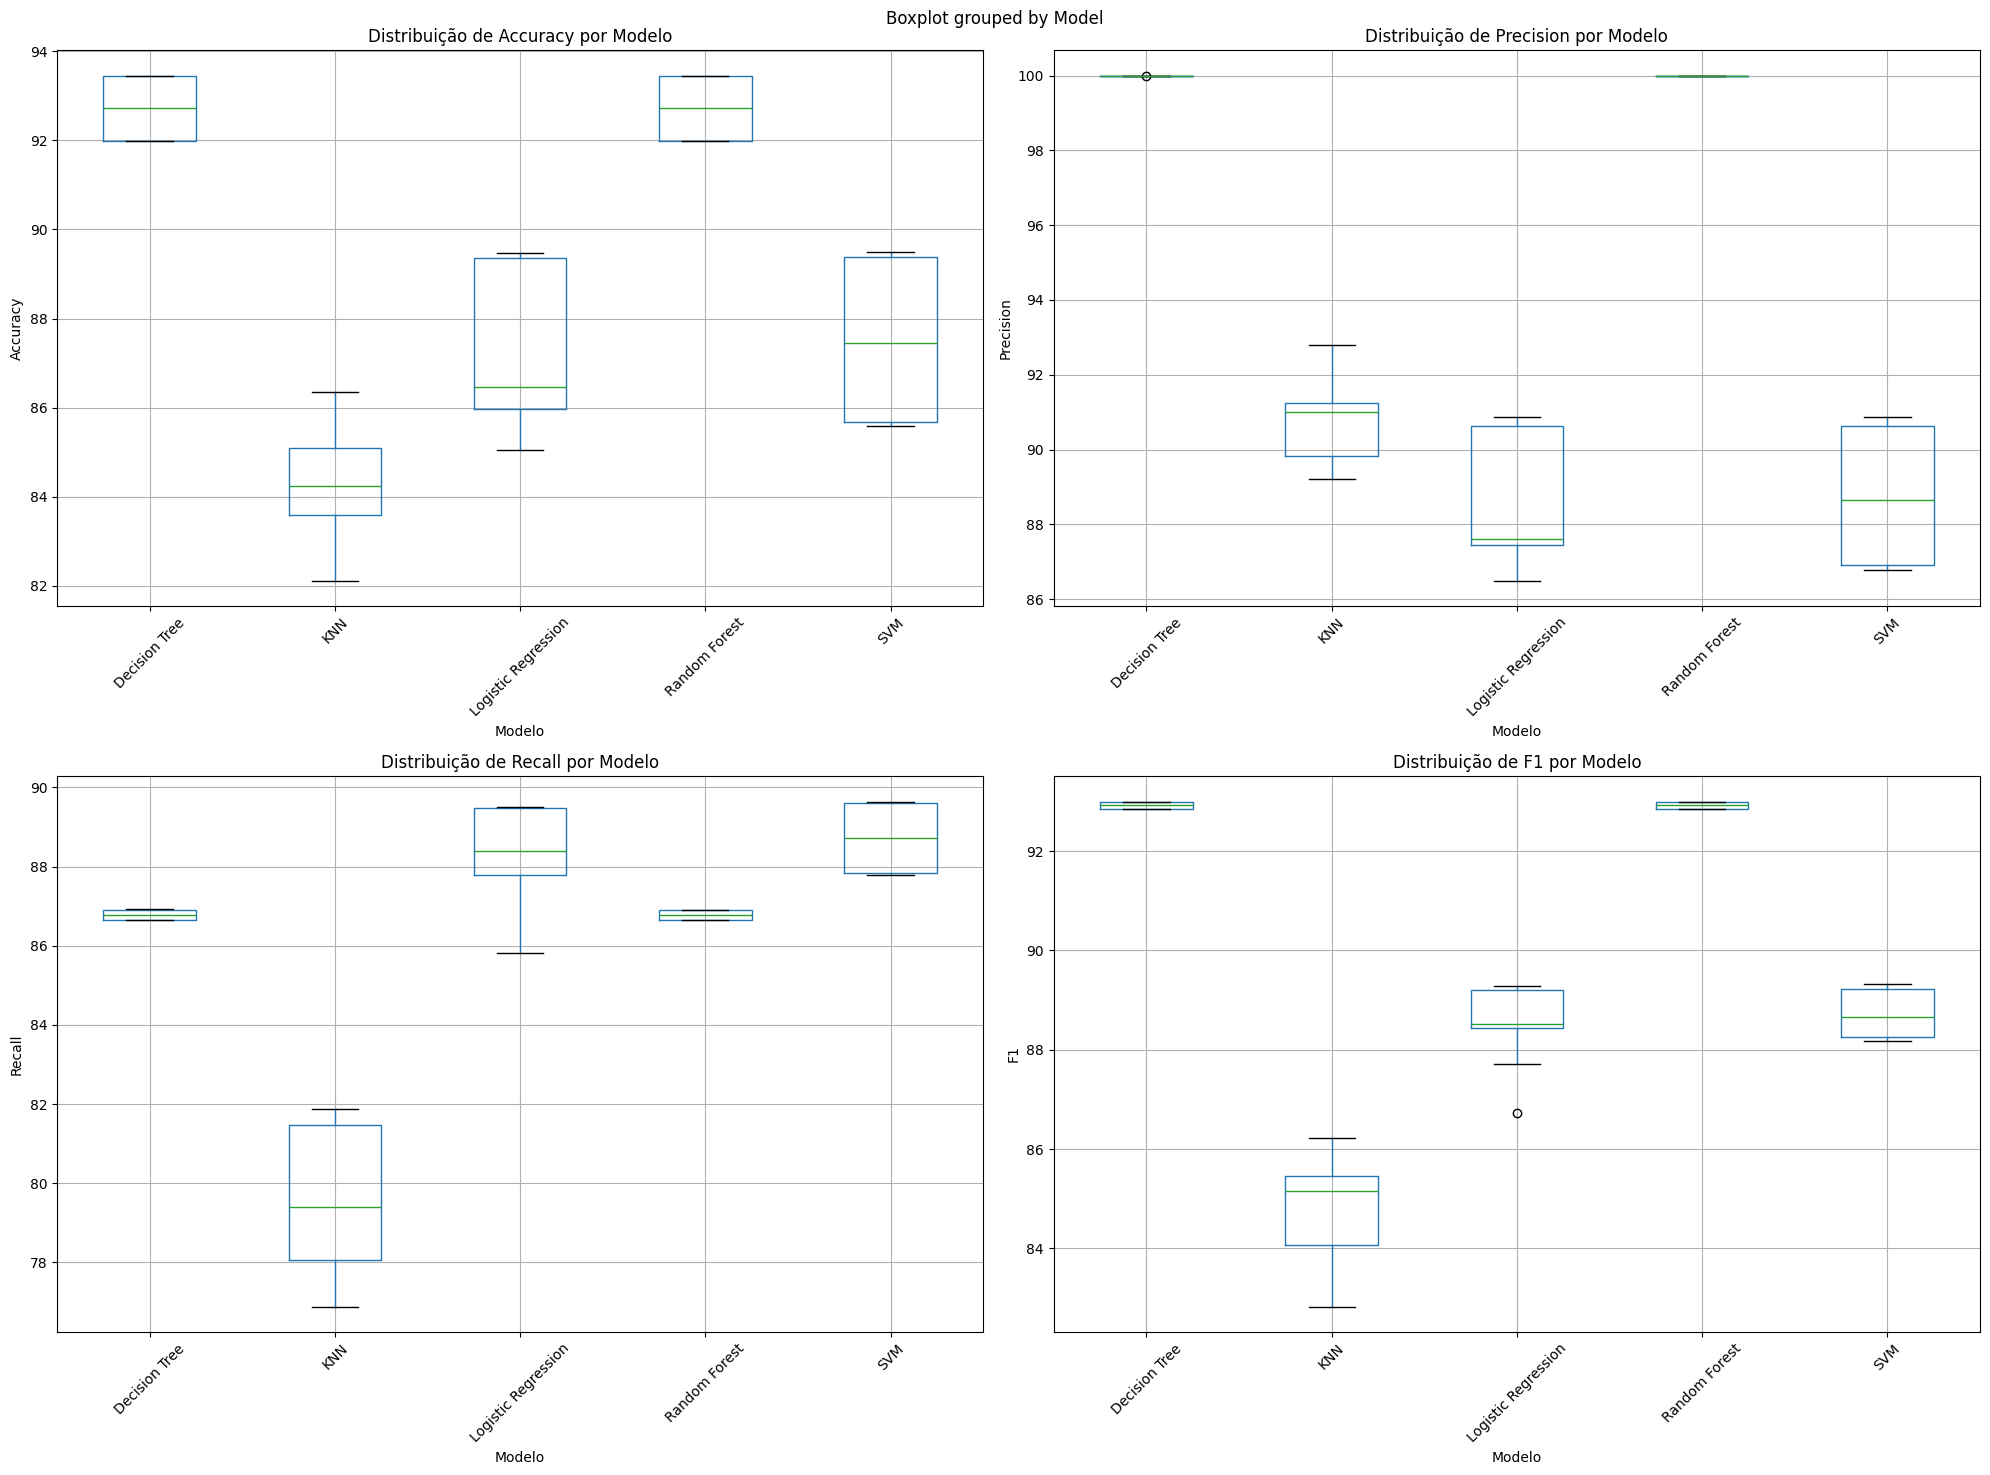

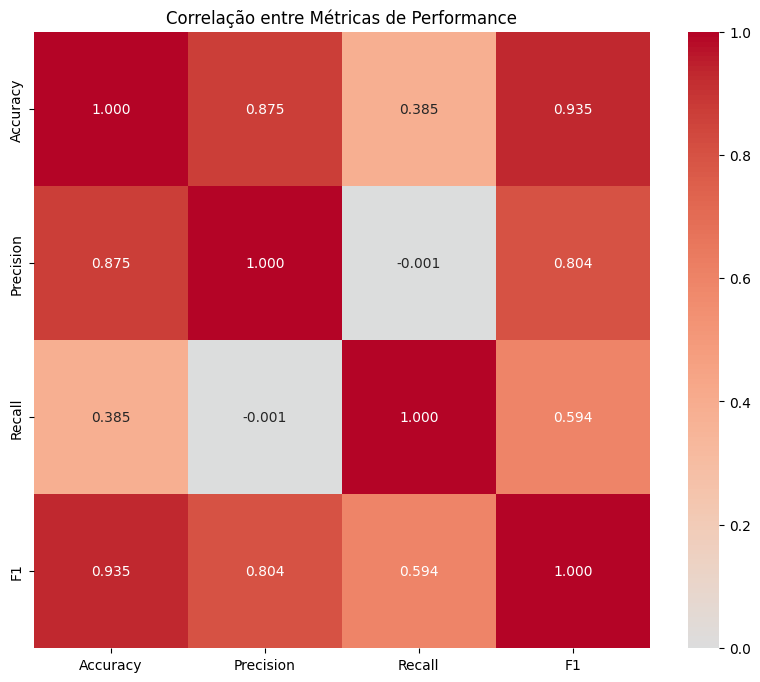

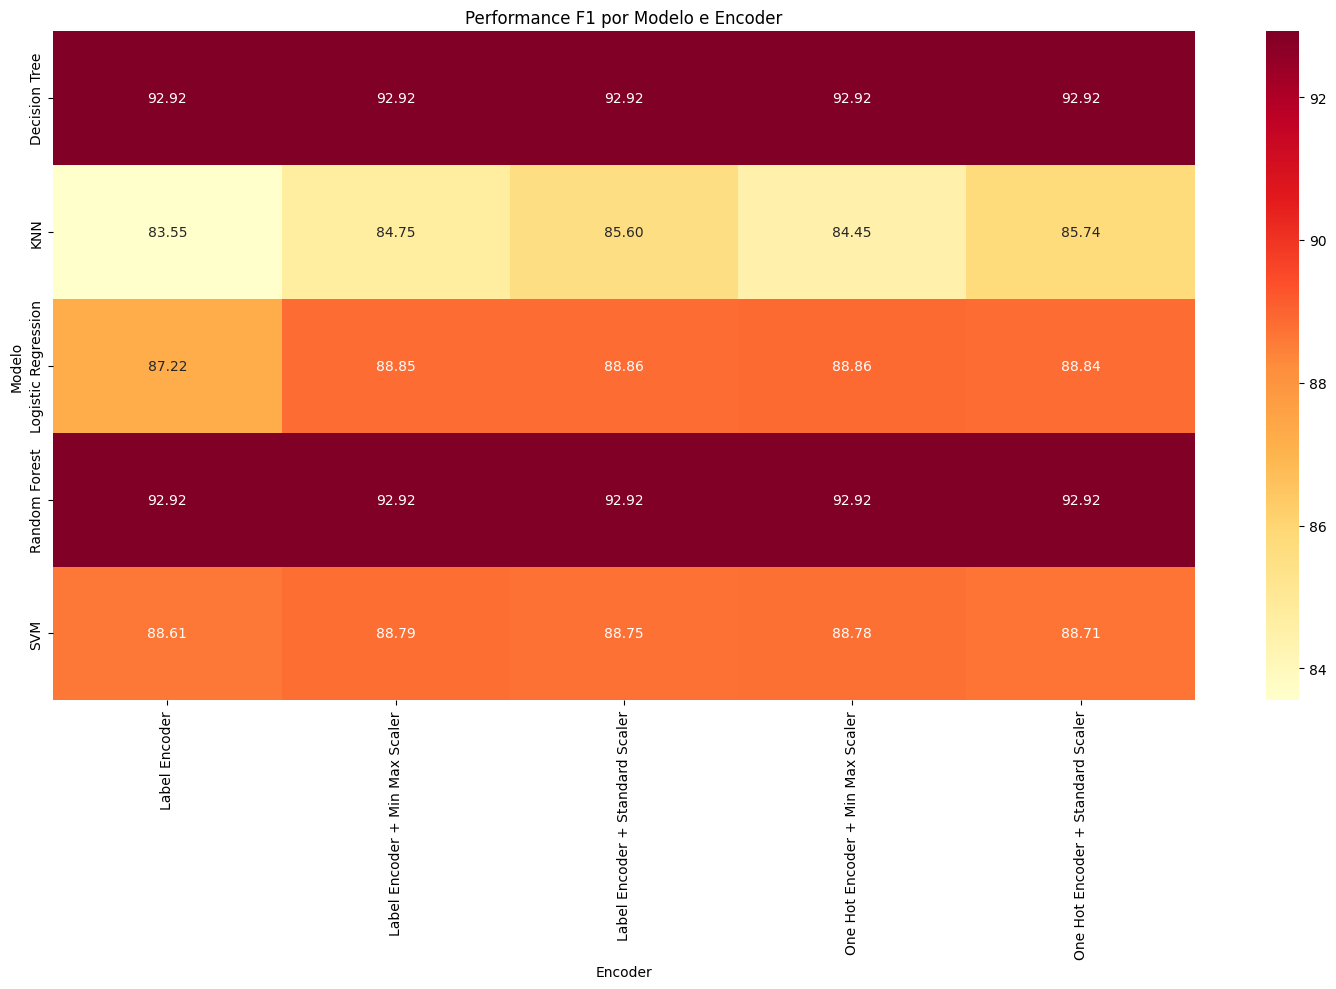

<Figure size 1500x800 with 0 Axes>

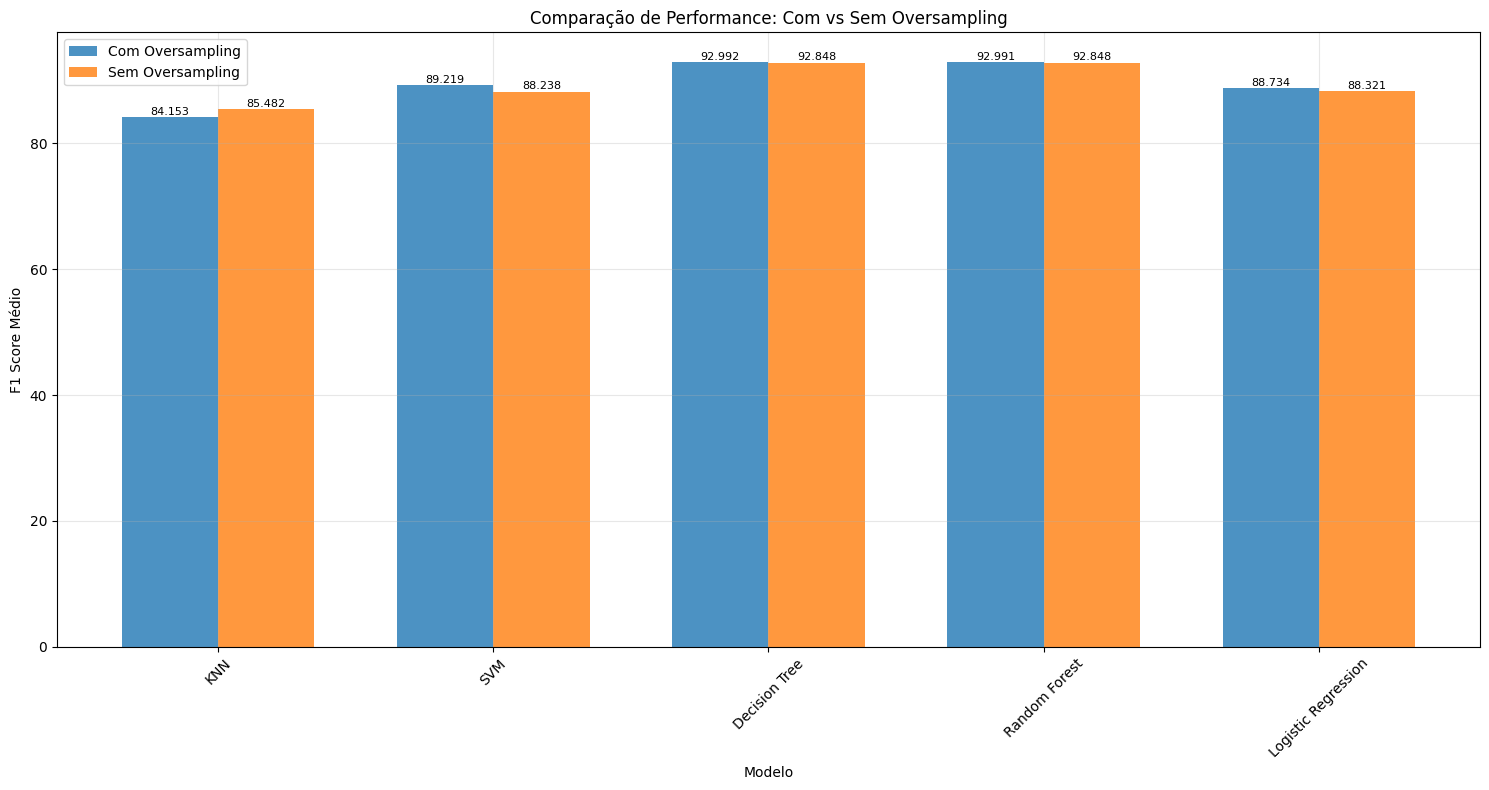

Visualizações criadas com sucesso!


In [16]:
# 13. VISUALIZAÇÕES DOS RESULTADOS

print("13.1 - Criando visualizações dos resultados...")

# Configurando o estilo dos gráficos
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. Boxplot das métricas por modelo
metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    results_df.boxplot(column=metric, by='Model', ax=ax)
    ax.set_title(f'Distribuição de {metric} por Modelo')
    ax.set_xlabel('Modelo')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Heatmap de correlação entre métricas
plt.figure(figsize=(10, 8))
correlation_matrix = results_df[['Accuracy', 'Precision', 'Recall', 'F1']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Correlação entre Métricas de Performance')
plt.show()

# 3. Comparação de modelos por encoder
plt.figure(figsize=(15, 10))

# Agrupando por modelo e encoder
model_encoder_performance = results_df.groupby(['Model', 'Encoder'])['F1'].mean().unstack()

# Criando heatmap
sns.heatmap(model_encoder_performance, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Performance F1 por Modelo e Encoder')
plt.xlabel('Encoder')
plt.ylabel('Modelo')
plt.tight_layout()
plt.show()

# 4. Comparação com e sem oversampling
plt.figure(figsize=(15, 8))

# Separando dados com e sem oversampling
with_oversampling = results_df[results_df['Oversampling'] == True]
without_oversampling = results_df[results_df['Oversampling'] == False]

# Plotando comparação
models = results_df['Model'].unique()
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 8))

# Calculando médias
with_os_means = [with_oversampling[with_oversampling['Model'] == model]['F1'].mean() for model in models]
without_os_means = [without_oversampling[without_oversampling['Model'] == model]['F1'].mean() for model in models]

bars1 = ax.bar(x - width/2, with_os_means, width, label='Com Oversampling', alpha=0.8)
bars2 = ax.bar(x + width/2, without_os_means, width, label='Sem Oversampling', alpha=0.8)

ax.set_xlabel('Modelo')
ax.set_ylabel('F1 Score Médio')
ax.set_title('Comparação de Performance: Com vs Sem Oversampling')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)

# Adicionando valores nas barras
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

print("Visualizações criadas com sucesso!")


In [17]:
# 14. RELATÓRIO FINAL E CONCLUSÕES

print("14.1 - Relatório Final dos Resultados")
print("=" * 80)

# Estatísticas gerais
print(f"\nTotal de experimentos realizados: {len(results_df)}")
print(f"Modelos testados: {len(results_df['Model'].unique())}")
print(f"Combinações de encoder testadas: {len(results_df['Encoder'].unique())}")

# Análise por modelo
print("\n14.2 - Performance média por modelo:")
model_performance = results_df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].mean()
print(model_performance.round(3))

# Análise por encoder
print("\n14.3 - Performance média por encoder:")
encoder_performance = results_df.groupby('Encoder')[['Accuracy', 'Precision', 'Recall', 'F1']].mean()
print(encoder_performance.round(3))

# Análise do impacto do oversampling
print("\n14.4 - Impacto do Oversampling:")
oversampling_analysis = results_df.groupby('Oversampling')[['Accuracy', 'Precision', 'Recall', 'F1']].mean()
print(oversampling_analysis.round(3))

# Top 5 melhores resultados
print("\n14.5 - Top 5 melhores resultados (F1 Score):")
top_5 = results_df.nlargest(5, 'F1')[['Model', 'Encoder', 'Oversampling', 'Accuracy', 'Precision', 'Recall', 'F1']]
print(top_5.round(3))

# Análise de variância
print("\n14.6 - Análise de variância dos resultados:")
variance_analysis = results_df.groupby('Model')[['Accuracy', 'Precision', 'Recall', 'F1']].std()
print("Desvio padrão por modelo:")
print(variance_analysis.round(3))

# Conclusões
print("\n14.7 - CONCLUSÕES:")
print("-" * 50)

# Melhor modelo geral
best_overall = results_df.loc[results_df['F1'].idxmax()]
print(f"• Melhor modelo geral: {best_overall['Model']}")
print(f"• Melhor encoder: {best_overall['Encoder']}")
print(f"• Oversampling: {'Sim' if best_overall['Oversampling'] else 'Não'}")
print(f"• F1 Score: {best_overall['F1']:.3f}")

# Análise de estabilidade
model_std = results_df.groupby('Model')['F1'].std()
most_stable = model_std.idxmin()
print(f"\n• Modelo mais estável: {most_stable} (std: {model_std[most_stable]:.3f})")

# Impacto do oversampling
f1_with_os = results_df[results_df['Oversampling'] == True]['F1'].mean()
f1_without_os = results_df[results_df['Oversampling'] == False]['F1'].mean()
os_impact = f1_with_os - f1_without_os
print(f"\n• Impacto do oversampling: {os_impact:+.3f} (F1 médio)")

if os_impact > 0:
    print("  → Oversampling melhora a performance geral")
else:
    print("  → Oversampling não melhora a performance geral")

# Recomendações
print(f"\n14.8 - RECOMENDAÇÕES:")
print("-" * 30)
print("• Para classificação de diabetes, recomenda-se:")
print(f"  - Modelo: {best_overall['Model']}")
print(f"  - Pré-processamento: {best_overall['Encoder']}")
print(f"  - Oversampling: {'Sim' if best_overall['Oversampling'] else 'Não'}")
print(f"  - Performance esperada: F1 = {best_overall['F1']:.1f}%")

print("\n" + "=" * 80)
print("ANÁLISE CONCLUÍDA COM SUCESSO!")
print("=" * 80)


14.1 - Relatório Final dos Resultados

Total de experimentos realizados: 50
Modelos testados: 5
Combinações de encoder testadas: 5

14.2 - Performance média por modelo:
                     Accuracy  Precision  Recall      F1
Model                                                   
Decision Tree          92.720     99.999  86.777  92.920
KNN                    84.380     90.799  79.606  84.817
Logistic Regression    87.358     88.699  88.390  88.527
Random Forest          92.720    100.000  86.775  92.919
SVM                    87.526     88.776  88.725  88.729

14.3 - Performance média por encoder:
                                   Accuracy  Precision  Recall      F1
Encoder                                                               
Label Encoder                        88.377     93.026  85.605  89.046
Label Encoder + Min Max Scaler       89.009     93.727  86.108  89.647
Label Encoder + Standard Scaler      89.174     93.895  86.263  89.808
One Hot Encoder + Min Max Scaler     8